### Imports

In [1]:
import atracker as atr
import ast
from importlib import reload
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import RegularGridInterpolator as RGI
from multiprocessing import Pool
from pybt.tools.parsers import read_twiss_file
from pybt.trackers.boris import track_to_condition
import warnings
import time
from IPython.display import Markdown as md
from IPython.core.display import display, HTML, Markdown
warnings.filterwarnings('ignore')
%matplotlib notebook

### Settings

In [2]:
particle = 'proton'       # particle name: 'proton' or 'carbon12'
en_per_unit_MeV = 26e3    # kinetic energy of the beam

# input angle and position of the beam in the global reference system
# values base on discussion with M. Fraser and https://codimd.web.cern.ch/05LpRgDIRIKUpRnTWTfbEA
PS_radius = 70.079
subtending_angle = (2*np.pi/100)
sagitta = PS_radius*(1-np.cos(subtending_angle/2))
offset = 310e-03*np.tan(subtending_angle/2)
chord = PS_radius*2*np.sin(subtending_angle/2)

length_drift = 1.0
x_offset = length_drift*np.sin(subtending_angle/2)
z_offset = length_drift*np.cos(subtending_angle/2)

track_end_z_m = chord/2+z_offset    # approximate location in longitudinal direction of the magnet at where to stop the tracking

ang_glob = (subtending_angle/2, 0.0)
pos_glob = (-(sagitta+x_offset),  0.0, -(chord/2+z_offset))

read_fm = True            # read out the field map
interpolate_fm = True     # prepare the interpolated field map for tracking
fm_path = '/eos/project-b/beam-transfer-physics/public/data/ps-main-unit-type-u/maps/' # path to the field map file
fm_file = 'MUU_xy_grid.table'
save_ref_traj = False     # save the reference trajectory to a file

# labels for parameters of the 6x6 transport matrix
var_labels = {
    "x": " x [m]",
    "y": " y [m]",
    "xp": " xp [rad]",
    "yp": " yp [rad]",
    "t": " T [m]",
    "D": " D [1]",
} 

### Load field map read and interpolate

In [3]:
if read_fm:
    df = pd.read_csv(fm_path+fm_file,delim_whitespace=True, skiprows=8, names=['x', 'y', 'z', 'Bx', 'By', 'Bz'])
    
    # mirroring the field map (wrt y=0) as only half of the magnet field is in the file
    df_mir = df.copy()
    df_mir[["y", "Bx", "Bz"]] = df_mir[["y", "Bx", "Bz"]].apply(np.negative)
    df_mir = df_mir.drop(df_mir[df_mir['y']==0.0].index)

    fieldmap = pd.concat([df, df_mir])

    fieldmap.sort_values(by=['x','y'], inplace=True)
    fieldmap['Bmod'] = np.sqrt(fieldmap['Bx']**2+fieldmap['By']**2+fieldmap['Bz']**2)
    for axis in ['x', 'y', 'z']:
        axis_val = fieldmap[axis].unique()
        print('In the direction {:} we have {:} values from {:} to {:} in steps of {:}'.format(axis, len(axis_val), axis_val.min(), axis_val.max(), np.unique(np.diff(axis_val)).mean().round(6)))

    print('And average fields are')    
    print(fieldmap[['Bx', 'By', 'Bz']].mean())    

if interpolate_fm:
    interp_fieldmap = atr.interpolate_fieldmap(fieldmap)

In the direction x we have 201 values from -0.76 to 0.76 in steps of 0.0076
In the direction y we have 201 values from -0.9 to 0.9 in steps of 0.009
In the direction z we have 527 values from -2.63 to 2.63 in steps of 0.01
And average fields are
Bx    8.162681e-19
By   -3.424371e-04
Bz    4.846168e-21
dtype: float64


### Functions

In [71]:
# magnetic field at position x at time based on the field map values
def func_B(x, time):
    """ return interpolated values of magnetic field components
    at point x and time """
    Bxi_p = interp_fieldmap['Bx'](x).squeeze()
    Byi_p = interp_fieldmap['By'](x).squeeze()
    Bzi_p = interp_fieldmap['Bz'](x).squeeze()
    f = open("/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt", "a")
    f.write(f"{x[0]},{x[1]},{x[2]},{Bxi_p},{Byi_p},{Bzi_p}\n")
    f.close()
    
    return np.array([Bxi_p, Byi_p, Bzi_p])
    
def track_one_particle(input_zip, time_step=4e-10, particle=particle):
    """ run one particle to condition 
    the initial particle parameters and the end-tracking condition is specified in input_zip """
    
    # distribution and type information on the particle plus the tracking-end condition
    id_part, x0, p0, t0, track_is_inside = input_zip

    xs, ps, ts, _ = track_to_condition(track_is_inside,
                                       x = x0,
                                       p = p0,
                                       t = t0,
                                       mass = atr.Particle(particle).get_e0_eV(),
                                       n_charges = atr.Particle(particle).get_z(),
                                       time_step = time_step,
                                       return_full_track = True,
                                       func_B = func_B)
    
    return pd.DataFrame({'id': [id_part] * len(xs),
                         'k': list(range(0, len(xs))),
                         'x': np.array(xs)[:, 0],
                         'y': np.array(xs)[:, 1],
                         'z': np.array(xs)[:, 2],
                         'Px': np.array(ps)[:, 0],
                         'Py': np.array(ps)[:, 1],
                         'Pz': np.array(ps)[:, 2],
                         't': np.array(ts)})

def trackend_plane(ref_particle, track_end_z_m):
    """ return the condition to finish the tracking of a whole set of particles
    based on the reference particle of distribution ref_particle
    and the approximate end condition track_end_z_m """
    
    # initial condition of end for the reference particle
    track_is_inside_ref = lambda x, p, t : x[2] < track_end_z_m
    input_zip = (ref_particle+(track_is_inside_ref,))
    
    # run reference particle
    tracks_ref = track_one_particle(input_zip)
    tracks_ref = atr.Tracks([tracks_ref], particle)

    return tracks_ref.get_track_condition() 

### Generate set of 13 particles

In [65]:
setGen = atr.SetGenerator(particle)

# distribution of the reference particle in local coordinate system 
distr_part_ref = {'dX': 0, 'dXP': 0, 'dY': 0, 'dYP': 0, 'dS': 0, 'en_MeV': en_per_unit_MeV, 'dt': 0}

# set of distributions for 13 particles in local coordinate system
set13_local = setGen.get_part13_local(distr_part_ref, dX=1e-3, dXP=1e-3, dY=1e-3, dYP=1e-3, dt=4e-12, dD=1e-3)

# set of distributions for 13 particles in global coordinate system to be used for tracking
set13_global = setGen.get_partset_global(set_local=set13_local, pos_glob0=pos_glob, ang_glob0=ang_glob)

# run reference particle to determine the tracking-end line for the entire set
plane_ref = trackend_plane(ref_particle=set13_global[0], track_end_z_m=track_end_z_m)
def track_is_inside(x ,p , t, a=plane_ref[0], b=plane_ref[1], c=plane_ref[2], d=plane_ref[3]):
#     return x[0] < (a * x[2] + c * x[1] + d  ) / b
    return x[2] < -(a * x[0] + b * x[1] + d  ) / c

### Run reference particle 0 and write to file it's position and B-field components

In [66]:
# Deletes the file content if it wasn't empty
f = open("/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt", "w")
f.write(f"") 
f.close()

# run the set of particles
input_zip = [set13_global[0]+(track_is_inside,) for i in range(1)]
with Pool(6) as p:
    tracks_set = p.map(track_one_particle, input_zip)

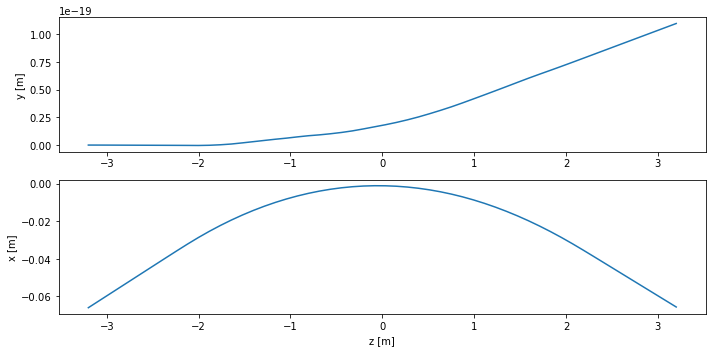

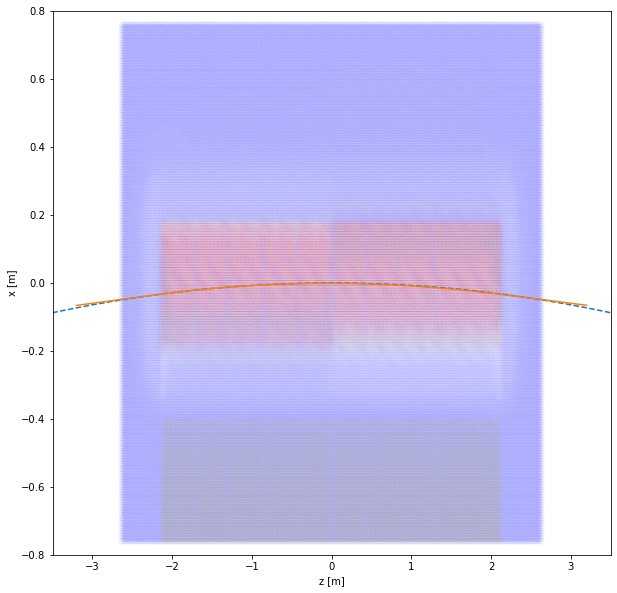

In [75]:
tracks = atr.Tracks(tracks_set, particle)
tracks.plot_track(pid=0, figsize=(10,5))
figure, axes = plt.subplots(1, figsize=(10,10))

theta = np.linspace(0, 2*np.pi, 10000)
radius = 70.079
fieldmapsmall = fieldmap.iloc[::50, :] #Takes one in n rows, resolution of fieldmap image. Higher number to calculate faster.

fieldmapsmall.sort_values(by=['By'], inplace=True) #Pour que les plus grand By soit dessiné en dernier
#linear mapping
slope_line=1/(fieldmapsmall["By"].max()-fieldmapsmall["By"].min())
b_line=1-slope_line*fieldmapsmall["By"].max()-3.424371e-04

axes.scatter(fieldmapsmall["z"], fieldmapsmall["x"], c=cm.seismic(slope_line*fieldmapsmall["By"]+b_line),alpha=0.005)

a = radius*np.cos(theta)
b = radius*np.sin(theta)-70.079
axes.plot(a, b, "--")
axes.plot(tracks.tracks_set[0]["z"],tracks.tracks_set[0]["x"])


plt.xlim([-3.5, 3.5])
plt.ylim([-0.8, 0.8])
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.show()

In [67]:
file = open('/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt', 'r')
Lines = file.readlines()

x,y,z,Bx,By,Bz = [],[],[],[],[],[]

for line in Lines:
    
    my_temp_list = []
    split = line.split(',')

    x.append(float(split[0]))
    y.append(float(split[1]))
    z.append(float(split[2]))
    Bx.append(float(split[3]))
    By.append(float(split[4]))
    Bz.append(float(split[5]))

In [68]:
field = pd.DataFrame()

field['x'] = x
field['y'] = y
field['z'] = z
field['Bx'] = Bx
field['By'] = By
field['Bz'] = Bz
field.head()

x             y         z            Bx        By            Bz
0 -0.064108  0.000000e+00 -3.140849 -1.124524e-19 -0.006197  1.041004e-18
1 -0.060343 -2.320683e-23 -3.021064 -6.462141e-20 -0.005717  6.196884e-19
2 -0.056577 -5.985825e-23 -2.901279 -7.872414e-21 -0.005231  8.782888e-20
3 -0.052809 -9.820965e-23 -2.781494  1.325064e-20 -0.004745 -1.098923e-19
4 -0.049042 -1.338903e-22 -2.661709  1.100284e-21 -0.004256  1.130767e-21

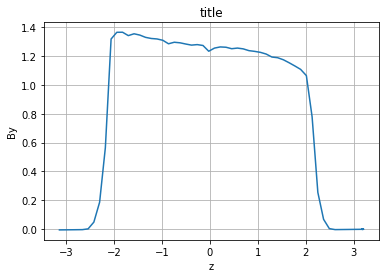

In [69]:
fig, ax = plt.subplots()
ax.plot(field.z, field.By)
ax.set(xlabel='z', ylabel='By',
       title='title')
ax.grid()

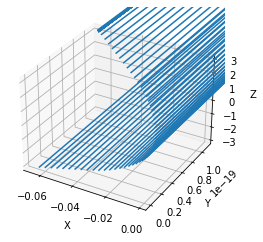

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(field.x,field.y,field.z,field.Bx,field.By,field.Bz)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
#ax.view_init(-90, 90)
plt.show()